# Network Prediction
Please run the ```Convallaria-Training.ipynb``` before.

In [1]:
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread
import sys

sys.path.append("../../../")
from unet.model import UNet
from deconoising.utils import PSNR
from deconoising import utils
from deconoising import prediction
import pn2v.training

# See if we can use a GPU
device = utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path = "./data/Convallaria_diaphragm/"
# Load the test data
dataTest = imread(path + "20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif")[
    :, :512, :512
]
# We are loading only a sub image to spped up computation
dataTest = dataTest - 520.0  # subtract a mean value for the background
# We estimate the ground truth by averaging.
dataTestGT = np.mean(dataTest[:, ...], axis=0)[np.newaxis, ...]

### Load the Network
Ensure that ```dataName``` is set same as in ```Convallaria-Training.ipynb```.

In [3]:
# Load the network, created in the 'Convallaria-Training.ipynb' notebook
dataName = "convallaria"  # Use the same name as used in training. This is a part of model name created in Convallaria-Training.ipynb
nameModel = "_network_example"
net = torch.load(path + "last_" + dataName + nameModel + ".net")

### Evaluation

image: 0
PSNR input 29.009240856174337
PSNR denoised 36.22980635174213
-----------------------------------
image: 1
PSNR input 29.018589127299936
PSNR denoised 36.16537640102502
-----------------------------------
image: 2
PSNR input 29.035458856560645
PSNR denoised 36.18265241211509
-----------------------------------
image: 3
PSNR input 28.990347509982925
PSNR denoised 36.17008075547048
-----------------------------------
image: 4
PSNR input 29.00285211368024
PSNR denoised 36.147463989244024
-----------------------------------
image: 5
PSNR input 29.02402327393454
PSNR denoised 36.17989244233054
-----------------------------------
image: 6
PSNR input 29.032053580418268
PSNR denoised 36.18099341165349
-----------------------------------
image: 7
PSNR input 29.017435705343363
PSNR denoised 36.186634695558666
-----------------------------------
image: 8
PSNR input 29.003677692102134
PSNR denoised 36.195325279499684
-----------------------------------
image: 9
PSNR input 28.9913484217094

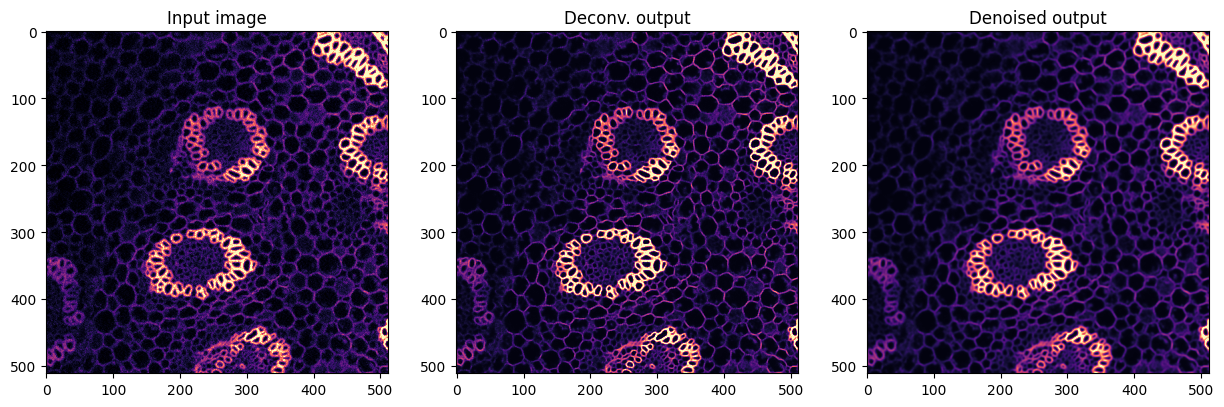

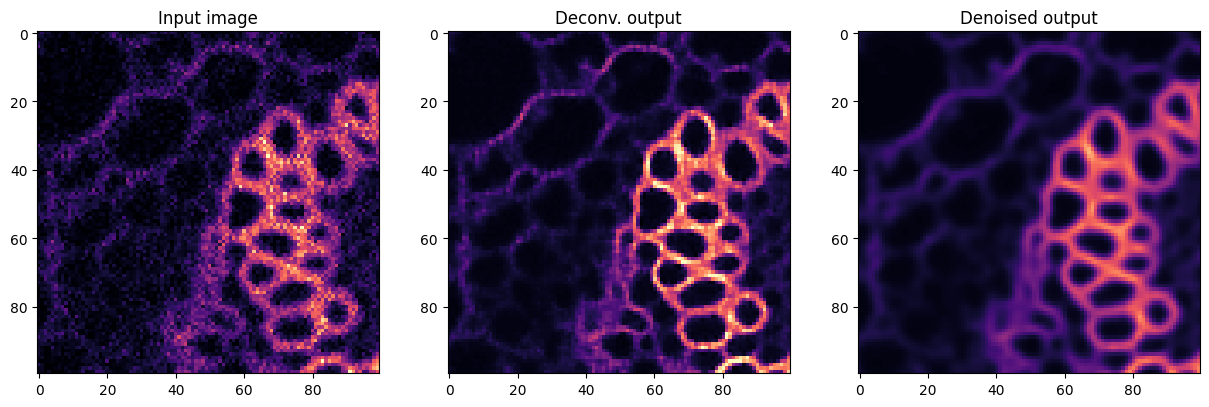

In [5]:
# Now we are processing data and calculating PSNR values.

psnr_result = []
psnr_input = []

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    im = dataTest[index]
    gt = dataTestGT[0]  # The ground truth is the same for all images

    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    # Here we are predicting the deconvolved and denoised image
    deconvolvedResult, denoisedResult = prediction.tiledPredict(
        net, im, ps=256, overlap=48, device=device
    )

    # calculate PSNR
    rangePSNR = np.max(gt) - np.min(gt)
    psnr_result.append(PSNR(gt, denoisedResult, rangePSNR))
    psnr_input.append(PSNR(gt, im, rangePSNR))
    print("image:", index)
    print("PSNR input", PSNR(gt, im, rangePSNR))
    print("PSNR denoised", PSNR(gt, denoisedResult, rangePSNR))
    print("-----------------------------------")

# We display the results for the last test image
vmi = np.percentile(gt, 0.01)
vma = np.percentile(gt, 99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title("Input image")
plt.imshow(im, vmax=vma, vmin=vmi, cmap="magma")

plt.subplot(1, 3, 2)
plt.title("Deconv. output")
plt.imshow(deconvolvedResult, vmax=vma, vmin=vmi, cmap="magma")

plt.subplot(1, 3, 3)
plt.title("Denoised output")
plt.imshow(denoisedResult, vmax=vma, vmin=vmi, cmap="magma")

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title("Input image")
plt.imshow(im[100:200, 150:250], vmax=vma, vmin=vmi, cmap="magma")

plt.subplot(1, 3, 2)
plt.title("Deconv. output")
plt.imshow(deconvolvedResult[100:200, 150:250], vmax=vma, vmin=vmi, cmap="magma")

plt.subplot(1, 3, 3)
plt.title("Denoised output")
plt.imshow(denoisedResult[100:200, 150:250], vmax=vma, vmin=vmi, cmap="magma")
print(
    "Avg PSNR input:",
    np.mean(np.array(psnr_input)),
    "+-(2SEM)",
    2 * np.std(np.array(psnr_input)) / np.sqrt(float(len(psnr_input))),
)
print(
    "Avg PSNR denoised:",
    np.mean(np.array(psnr_result)),
    "+-(2SEM)",
    2 * np.std(np.array(psnr_result)) / np.sqrt(float(len(psnr_result))),
)